In [2]:
response = {
    "articles": [
        {
            "title": "Prime Minister inaugurates the $400 temple in Kanpur"
        },
        {
            "title": "President launches new initiative"
        }
    ]
}

In [3]:
import spacy
import re

nlp = spacy.load("en_core_web_sm")

def get_main_verb(sentence):
    doc = nlp(sentence)
    main_verb = None
    for token in doc:
        if token.pos_ == "VERB" and token.dep_ != "aux":
            main_verb = token.text
            break
    return main_verb

In [4]:
from DataModelling import DataModel

data_model = DataModel()


for article in response["articles"]:
    title = article["title"]
    main_verb = get_main_verb(title)
    custom_pattern = re.compile(fr'(?P<entity1>.+?)\s+(?P<relation>\b(?:{main_verb})\b)\s+(?P<entity2>.+)')
    match = custom_pattern.match(title)
    entity1 = match.group("entity1").strip()
    entity2 = match.group("entity2").strip()
    relation = match.group("relation").strip()
    data_model.add_entity(entity1)
    data_model.add_entity(entity2)
    data_model.add_relation(relation, [
        entity1,
        entity2
    ])
    data_model.save_to_csv()
    print(f"Added {entity1} {relation} {entity2} to the data model")

Added Prime Minister inaugurates the $400 temple in Kanpur to the data model
Added President launches new initiative to the data model


C:\Users\Aditya\AppData\Local\Temp\ipykernel_21664\2192456117.py:60: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate(


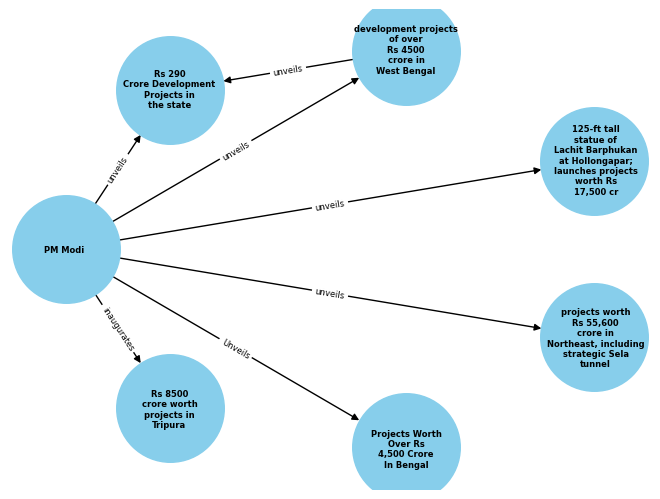

<Figure size 2000x2000 with 0 Axes>

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

data = [
    {
        "Entity1": "PM Modi",
        "Entity2": "Rs 8500 crore worth projects in Tripura",
        "Relation": "inaugurates"
    },
    {
        "Entity1": "PM Modi",
        "Entity2": "Projects Worth Over Rs 4,500 Crore In Bengal",
        "Relation": "Unveils"
    },
    {
        "Entity1": "PM Modi",
        "Entity2": "projects worth Rs 55,600 crore in Northeast, including strategic Sela tunnel",
        "Relation": "unveils"
    },
    {
        "Entity1": "PM Modi",
        "Entity2": "125-ft tall statue of Lachit Barphukan at Hollongapar; launches projects worth Rs 17,500 cr",
        "Relation": "unveils"
    },
    {
        "Entity1": "PM Modi",
        "Entity2": "development projects of over Rs 4500 crore in West Bengal",
        "Relation": "unveils"
    },
    {
        "Entity1": "PM Modi",
        "Entity2": "Rs 290 Crore Development Projects in the state",
        "Relation": "unveils"
    },
    {
        "Entity1": "development projects of over Rs 4500 crore in West Bengal",
        "Entity2": "Rs 290 Crore Development Projects in the state",
        "Relation": "unveils"
    }
]

G = nx.DiGraph()

# Add nodes and edges in the order they appear in the data
for item in data:
    G.add_node(item["Entity1"])
    G.add_node(item["Entity2"])
    G.add_edge(item["Entity1"], item["Entity2"], relation=item["Relation"])

# Use shell layout
pos = nx.shell_layout(G)

# Draw the graph without labels
nx.draw(G, pos, node_color='skyblue', node_size=6000, edge_cmap=plt.cm.Blues)

# Add multiline labels
for node, (x, y) in pos.items():
    words = node.split(' ')
    lines = [' '.join(words[i:i+2]) for i in range(0, len(words), 2)]
    plt.annotate(
        '\n'.join(lines),
        xy=(x, y), textcoords='offset points',
        horizontalalignment='center', verticalalignment='center',
        fontsize=6, weight='bold'
    )

edge_labels = nx.get_edge_attributes(G, 'relation')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

plt.figure(figsize=(20, 20))
plt.show()